In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

In [7]:
import simpy

# シンプルなシナリオ

- 1日に１回コーヒーをのみたくなる。
- 

In [459]:
DATA_FILE = "./data.csv"
def log_simulation(m):
    with open(DATA_FILE,"a") as f:
        f.write(m+"\n")

def clear_datafile():
    with open(DATA_FILE,"w") as f:
        f.write("")

class Person(object):
    def __init__(self, env, name, freq):
        self.env = env
        self.name = name
        self.freq = freq

    def is_need_to_go(self):
        if np.random.randint(SIM_SIZE)  <= self.freq:
                log_simulation("%s,%d,コーヒー飲みたい！" % (self.name, self.env.now))
                return True
        else:
                log_simulation("%s,%d,仕事しよ..." % (self.name, self.env.now))
                return False

    def run(self):
        while True:
            if self.is_need_to_go():
                with coffee_garden.request() as req:
                    yield req
                    yield self.env.timeout(2) # コーヒーを淹れる時間
                    log_simulation("%s,%d,おいしかった！！" % (self.name, self.env.now))
            yield self.env.timeout(1)


In [460]:
SIM_SIZE = 10
FREQ = 1
POPULATION = 3
env = simpy.Environment()

coffee_garden = simpy.Resource(env, 2)

for name in ["person_%03d" % i for i in np.arange(0,POPULATION,1)]:
    env.process(Person(env, name, FREQ).run())

clear_datafile()
        
env.run(until=SIM_SIZE)

In [461]:
dat = pd.read_csv("./data.csv", header=None)

In [462]:
dat.columns=["name","time","state"]
dat.pivot("time","name","state")

name,person_000,person_001,person_002
time,,,
0,仕事しよ...,仕事しよ...,コーヒー飲みたい！
1,仕事しよ...,コーヒー飲みたい！,None
2,仕事しよ...,None,おいしかった！！
3,コーヒー飲みたい！,おいしかった！！,仕事しよ...
4,None,仕事しよ...,仕事しよ...
5,おいしかった！！,仕事しよ...,仕事しよ...
6,コーヒー飲みたい！,コーヒー飲みたい！,コーヒー飲みたい！
8,おいしかった！！,おいしかった！！,None
9,コーヒー飲みたい！,コーヒー飲みたい！,None


# 少し現実ぽくシナリオを組んでみる

- 1単位時間を１分として営業時間の８時間＝60min x 8
- 毎日行く人もいると思うけど全員ではない。FREQも１日０回〜2回のランダムで
- 社員数は３００人
- バリスタさんは3人常駐してくれている。

- 課題を再設定：１日の待ち人数の最大はどのくらいだろうか

In [463]:
# スタンドの前で待つ人のモニタリング
def monitor(resource, env):
    while True:
        log_simulation("Brewing,%d,%d" % (resource._env.now, resource.count))
        log_simulation("Waiting,%d,%d" % (resource._env.now, len(resource.queue)))
        yield env.timeout(1)

In [471]:
DATA_FILE = "./data.csv"
def log_simulation(m):
    with open(DATA_FILE,"a") as f:
        f.write(m+"\n")

def clear_datafile():
    with open(DATA_FILE,"w") as f:
        f.write("")

class Person(object):
    def __init__(self, env, name, freq):
        self.env = env
        self.name = name
        self.freq = freq

    def is_need_to_go(self):
        return np.random.randint(SIM_SIZE) < self.freq

    def run(self):
        while True:
            if self.is_need_to_go():
                with coffee_garden.request() as req:
                    yield req
                    yield self.env.timeout(2) # コーヒーを淹れる時間
                    #log_simulation("%s,%d,おいしかった！！" % (self.name, self.env.now))
            yield self.env.timeout(1)


In [492]:
SIM_SIZE = 60*8
NUM_OF_PEOPLE = 300
NUM_OF_BRISTA = 3


def get_random_freq():
    return np.random.randint(2)

env = simpy.Environment()

coffee_garden = simpy.Resource(env, NUM_OF_BRISTA)

for name in ["person_%03d" % i for i in np.arange(0,NUM_OF_PEOPLE,1)]:
    env.process(Person(env, name, get_random_freq()).run())

env.process(monitor(coffee_garden, env))
    
clear_datafile()    
env.run(until=SIM_SIZE)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1242fdd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x123df2048>]], dtype=object)

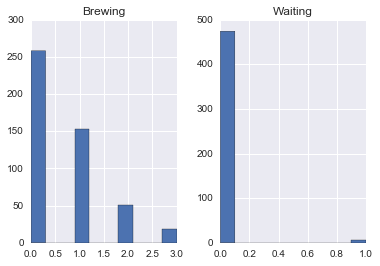

In [493]:
dat = pd.read_csv("./data.csv", header=None)
dat.columns=["name","time","state"]
res = dat.pivot("time","name","state")
res.hist()

# グラフを見て分析してみる

- Brewing(コーヒーを淹れてもらっている状態) の最大は２なので、バリスタさんが２人を相手にコーヒーを淹れてるタイミングがある。１００前後なので１日の2割弱。
- Waiting(先客がいて注文できていない状態)の最大は１、かつ１日のうちのごくわずか。

３人もいてくれればほとんど待たずにコーヒーが飲める！！

# さらに現実ぽくシナリオを組んでみる

- 1単位時間を１分として営業時間の８時間＝60min x 8
- 毎日行く人もいると思うけど全員ではない。FREQも１日０回〜2回のランダムで
    - [NEW！！] 朝の１時間、昼休みの１時間はよりコーヒーを飲みたくなる
- 社員数は３００人
- バリスタさんは3人常駐してくれている。
- [NEW!!] たまに仲間を１〜２人連れてコーヒーを買いに行く。


In [535]:
DATA_FILE = "./data.csv"

# スタンドの前で待つ人のモニタリング
def monitor(resource, env):
    while True:
        #log_simulation("Brewing,%d,%d" % (resource._env.now, resource.count))
        #log_simulation("Waiting,%d,%d" % (resource._env.now, len(resource.queue)))
        yield env.timeout(1)

def log_simulation(m):
    with open(DATA_FILE,"a") as f:
        f.write(m+"\n")

def clear_datafile():
    with open(DATA_FILE,"w") as f:
        f.write("")

def is_morning(current_time):
    return current_time > 0 and current_time < 24

def is_after_lanch(current_time):
    return current_time > 24*12 and current_time < 24*13

class Person(object):
    people = []
    def __init__(self, env, name, freq):
        self.env = env
        self.name = name
        self.freq = freq
        self.accompanied = False

    def is_need_to_go(self):
        freq = self.freq
        if is_morning(self.env.now):
            freq = self.freq + 1

        if is_after_lanch(self.env.now):
            freq = self.freq + 1
        
        return np.random.randint(SIM_SIZE) < freq

    def accompany_someone(self):
        if self.accompanied:
            return None  # すでに誘ったメンバー
        for i in range(0, np.random.randint(2),1):
            pid = np.random.randint(NUM_OF_PEOPLE)
            self.people[pid].accompanied=True
    
    def run(self):
        while True:
            if self.is_need_to_go() or self.accompanied:
                self.accompany_someone()
                with coffee_garden.request() as req:
                    yield req
                    if self.accompanied:
                        log_simulation("%s,%d,さそわれて。" % (self.name, self.env.now))
                    else:
                        log_simulation("%s,%d,飲みに来た。" % (self.name, self.env.now))
                    yield self.env.timeout(2) # コーヒーを淹れる時間
                    #log_simulation("%s,%d,おいしかった！！" % (self.name, self.env.now))
            self.accompanied = False
            yield self.env.timeout(1)


In [551]:
SIM_SIZE = 60*8
NUM_OF_PEOPLE = 300
NUM_OF_BRISTA = 2
FREQ_FOR_ACCOMPANY = 1

def get_random_freq():
    return np.random.randint(2)

env = simpy.Environment()

coffee_garden = simpy.Resource(env, NUM_OF_BRISTA)

for name in ["person_%03d" % i for i in np.arange(0,NUM_OF_PEOPLE,1)]:
    p = Person(env, name, get_random_freq())
    Person.people.append(p)
    env.process(p.run())

env.process(monitor(coffee_garden, env))
    
clear_datafile()    
env.run(until=SIM_SIZE)

In [552]:
from collections import Counter

In [553]:
dat = pd.read_csv("./data.csv", header=None)
dat.columns=["name","time","state"]
Counter(dat.state.values)
#res = dat.pivot("time","name","state")
#res

Counter({'飲みに来た。': 191})